# Exoplanet Transit Classification (Kepler Mission)
## Modeling

In [182]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from copy import deepcopy

# this class is needed for loading the preprocessing pipeline 
import sys
sys.path.append("..\\src\\")
from exo_preprocess import SqrtLogZeroExceptionTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef as mcc


In [132]:
# load train and test features and labels
base_data_path = "..\\data\\processed\\"
X_train = pd.read_csv(base_data_path + 'X_train.csv', index_col=['KIC_ID', 'TCE_num'] )
y_train = pd.read_csv(base_data_path + 'y_train.csv', index_col = ['KIC_ID', 'TCE_num'] )
X_test = pd.read_csv(base_data_path + 'X_test.csv', index_col=['KIC_ID', 'TCE_num'] )
y_test = pd.read_csv(base_data_path + 'y_test.csv', index_col=['KIC_ID', 'TCE_num'] )

In [133]:
# load preprocessing pipeline
pipeline_base_path = "..\\models\\preprocessing\\"
preprocess_pipeline = pickle.load(open(pipeline_base_path + 'preprocess_pipeline.pkl', 'rb'))

#### Let's construct a pipeline that does the data preprocessing steps and then feeds it into a Random forest classifier. 

## I. Random Forest + Hyperparameter Tuning 

In [134]:
full_pipeline = deepcopy(preprocess_pipeline)
full_pipeline.steps.append(('exo_randforest', RandomForestClassifier()))
print(full_pipeline)

Pipeline(steps=[('sqrtlog', SqrtLogZeroExceptionTransformer()),
                ('lpptrans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('lpp',
                                                  LocalityPreservingProjection(),
                                                  ['LCBIN_0', 'LCBIN_1',
                                                   'LCBIN_2', 'LCBIN_3',
                                                   'LCBIN_4', 'LCBIN_5',
                                                   'LCBIN_6', 'LCBIN_7',
                                                   'LCBIN_8', 'LCBIN_9',
                                                   'LCBIN_10', 'LCBIN_11',
                                                   'LCBIN_12', 'LCBIN_13',
                                                   'LCBIN_14', 'LCBIN_15',
                                                   'LCBIN_16', 'LCBIN_17',
                                           

#### FLAG: How do I optimize hyperparameters on the lpp dim reduction?

Let's do a 5-fold cross-validation using the full pipeline. The importance of putting the data preprocessing transformations into the pipeline can not be stressed enough when doing CV. CV with full_pipeline will fit the preprocessing and modeling on 4 of the folds of the training set and then use this pre-process training to transform the last fold and evaluate the model on it. 

This will thus not be the fitted preprocessing that we pickled from the previous notebook which was over the entire training set. This avoids data leakage within the cross validation.

In [137]:
# set parameter grid. max feature optimal should be around sqrt(n_features) ~ 3. But we'll play around with this hyperparameter. We'll use default criterion of gini impurity.

parameters = {'exo_randforest__n_estimators': np.arange(50,800,50), 'exo_randforest__max_depth': np.arange(3,21,3), 'exo_randforest__max_features':  np.arange(2,7,1)}
# the parameters form a large grid: let's do 30 random samples in the defined hyperparameter space. We may not get the optimal model but hopefully should be good enough.
exo_cv = RandomizedSearchCV(full_pipeline, param_distributions = parameters, n_iter = 50, cv = 5, scoring = 'f1_micro')

In [138]:
y_train_flat = y_train.to_numpy().flatten() #need to do this for sklearn's fit 
exo_cv.fit(X_train, y_train_flat)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sqrtlog',
                                              SqrtLogZeroExceptionTransformer()),
                                             ('lpptrans',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('lpp',
                                                                               LocalityPreservingProjection(),
                                                                               ['LCBIN_0',
                                                                                'LCBIN_1',
                                                                                'LCBIN_2',
                                                                                'LCBIN_3',
                                                                                'LCBIN_4',
                                     

Let's take a look at how the top models performed under cross validation. The F1 micro-averaged score on the splits for the top model are pretty good. The aggregated mean f1 micro-averaged score is ~ 0.87 which is very good. There is hope that this model will generalize well.

In [139]:
pd.DataFrame(exo_cv.cv_results_).sort_values(by = 'rank_test_score').head(8)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_exo_randforest__n_estimators,param_exo_randforest__max_features,param_exo_randforest__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,12.159891,0.191360,0.227122,0.006915,700,3,18,"{'exo_randforest__n_estimators': 700, 'exo_ran...",0.860593,0.857143,0.875824,0.879121,0.871429,0.868822,0.008556,1
10,7.348168,0.102474,0.089690,0.004907,300,3,15,"{'exo_randforest__n_estimators': 300, 'exo_ran...",0.857300,0.856044,0.873626,0.882418,0.871429,0.868163,0.010086,2
26,11.694747,0.095552,0.230787,0.010134,750,3,18,"{'exo_randforest__n_estimators': 750, 'exo_ran...",0.859495,0.857143,0.871429,0.883516,0.868132,0.867943,0.009410,3
5,7.815705,0.292117,0.065182,0.004526,200,5,18,"{'exo_randforest__n_estimators': 200, 'exo_ran...",0.851811,0.861538,0.873626,0.886813,0.864835,0.867725,0.011824,4
23,8.594797,0.145254,0.186601,0.006115,650,2,15,"{'exo_randforest__n_estimators': 650, 'exo_ran...",0.856202,0.854945,0.872527,0.882418,0.871429,0.867504,0.010474,5
19,12.760239,0.108688,0.158596,0.009527,550,5,18,"{'exo_randforest__n_estimators': 550, 'exo_ran...",0.851811,0.858242,0.874725,0.885714,0.864835,0.867066,0.012016,6
47,7.550221,0.030404,0.081182,0.004515,300,4,15,"{'exo_randforest__n_estimators': 300, 'exo_ran...",0.856202,0.856044,0.870330,0.883516,0.868132,0.866845,0.010214,7
8,10.367258,0.101016,0.131357,0.000775,500,4,12,"{'exo_randforest__n_estimators': 500, 'exo_ran...",0.859495,0.854945,0.872527,0.882418,0.864835,0.866844,0.009741,8


Let's take the best model from this Randomized CV Search.

In [140]:
bestmod = exo_cv.best_estimator_
bestmod

Pipeline(steps=[('sqrtlog', SqrtLogZeroExceptionTransformer()),
                ('lpptrans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('lpp',
                                                  LocalityPreservingProjection(),
                                                  ['LCBIN_0', 'LCBIN_1',
                                                   'LCBIN_2', 'LCBIN_3',
                                                   'LCBIN_4', 'LCBIN_5',
                                                   'LCBIN_6', 'LCBIN_7',
                                                   'LCBIN_8', 'LCBIN_9',
                                                   'LCBIN_10', 'LCBIN_11',
                                                   'LCBIN_12', 'LCBIN_13',
                                                   'LCBIN_14', 'LCBIN_15',
                                                   'LCBIN_16', 'LCBIN_17',
                                           

The best estimator picks roughly a sqrt(n_features) ~ 3 subset of the features for each tree in the forest, the forest consisting of 700 trees with a fairly deep depth of ~ 18. Now let's train this model on the entire training set and then evaluate our model on our hold out.

In [141]:
bestmod.fit(X_train,y_train_flat)
y_pred = bestmod.predict(X_test) # this transforms X_test according to the LPP and sqrtlogTransformer fit values trained on X_train and runs the random forest prediction based off of the fit to X_train.
y_test_flat = y_test.to_numpy().flatten()

### Random Forest "Best" Model Evaluation

In [162]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.92      0.96      0.94       351
           2       0.86      0.89      0.87       321
           3       0.80      0.65      0.72       132

    accuracy                           0.88       804
   macro avg       0.86      0.83      0.84       804
weighted avg       0.88      0.88      0.88       804



This is pretty good. The precision, recall, and f1-score on class 1 (i.e. actual exoplanet identification) in particular are excellent. Identification of secondary eclipse false positives (i.e. possibly eclipsing binary star systems) are also pretty solid. The only class that has not the greatest recall (and consequently somewhat poorer f1-score than the other classes) is Class 3 (the non-transiting phenomena). 

The recall (tp/(tp + fn)) being relatively low implies that some observations flagged in the Kepler Input Catalog as possible non-transiting phenomena are being attributed to other classes. The confusion matrix should help us figure out whats going on:

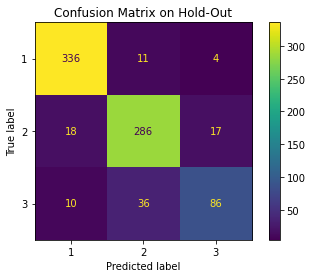

In [158]:
plot_confusion_matrix(bestmod, X_test, y_test_flat)
plt.title('Confusion Matrix on Hold-Out')
plt.show()

The main issue with Class 3 can now be seen pretty clearly. Light curves flagged by the Kepler Cumulative Table as non-transiting phenomena are being interpreted by our pipeline as secondary eclipse false positives. Actually, we came across this in the first section of our EDA when we noticed that there were light curves that looked like secondary eclipse false positives flagged as non-transiting phenomena. 

It's likely that these example were flagged as non-transiting phenomena due to specific features in the telescope's image pixel capture (something that has been averaged away when just looking at the light curves). So, in essence, the algorithm probably wouldn't be able to distinguish these examples from class 2 given the data we have fed it. But we can see that this is exactly why the recall in class 3 is not the greatest.

What is good is that this is the largest source of confusion in classification and it is between the two false positive classes. Actual exoplanets are not often attributed to the false positive classes. 

Also, our algorithm seems to be doing a good job at identifying secondary eclipse phenomena (i.e. possible eclipsing binary systems). A good deal of this probably can be attributed to the fact that some of the features were specifically designed with secondary eclipse identification in mind. 

On that note, let's look at the feature importances:


In [179]:
feat_cols = ['LPP_1', 'LPP_2', 'Period', 'Duration', 'even_odd_stat', 'p_secondary', 'max', 'min']
feature_importance_series = pd.Series(bestmod['exo_randforest'].feature_importances_, index = feat_cols).sort_values()
print(feature_importance_series)

even_odd_stat    0.048660
max              0.061525
LPP_2            0.074501
Duration         0.089307
Period           0.135407
p_secondary      0.151163
min              0.216920
LPP_1            0.222517
dtype: float64


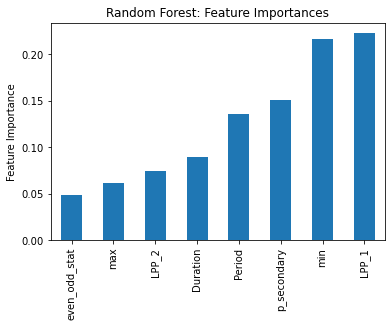

In [180]:
feature_importance_series.plot(kind = 'bar')
plt.ylabel('Feature Importance')
plt.title('Random Forest: Feature Importances')
plt.show()

It's pretty clear that all of the light curve extracted features are useful in the classification to varying degrees.

Finally, let's print out the matthews correlation coefficient as a single citing metric for the goodness of this model and then we can pickle the entire pipeline with the model and save it.

In [184]:
#This is the matthews correlation coefficient for our multiclass classification. Actually, pretty decent.
print(mcc(y_test,y_pred))

0.8069237470061394


In [186]:
# pickle pipeline for best random forest model and save
model_path = "..\\models\\randomforest_pipeline.pkl"
pickle.dump(bestmod, open(model_path, 'wb'))

## II. Kernelized SVM + Hyperparameter Optimization

In [217]:
from sklearn.svm import SVC

In [295]:
full_pipeline.steps.pop(-1)

('exo_SVC', SVC())

In [296]:
full_pipeline.steps.append(('exo_SVC', SVC(kernel = 'rbf')))
print(full_pipeline)

Pipeline(steps=[('sqrtlog', SqrtLogZeroExceptionTransformer()),
                ('lpptrans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('lpp',
                                                  LocalityPreservingProjection(),
                                                  ['LCBIN_0', 'LCBIN_1',
                                                   'LCBIN_2', 'LCBIN_3',
                                                   'LCBIN_4', 'LCBIN_5',
                                                   'LCBIN_6', 'LCBIN_7',
                                                   'LCBIN_8', 'LCBIN_9',
                                                   'LCBIN_10', 'LCBIN_11',
                                                   'LCBIN_12', 'LCBIN_13',
                                                   'LCBIN_14', 'LCBIN_15',
                                                   'LCBIN_16', 'LCBIN_17',
                                           

The Kernelized SVM's performance will be quite dependent on tuning the hyperparameters C and gamma which are the slack/soft-margin regularization and the RBF inverse length parameter respectively. We'll first do a GridSearchCV of the parameters on an exponential scale:

In [301]:
parameters = {'exo_SVC__C': [.01, .1, 1, 10, 100, 1000], 'exo_SVC__gamma': [.01,.1,1,10,100]}
exo_SVM_cv = GridSearchCV(full_pipeline, param_grid = parameters, cv = 5, scoring = 'f1_micro')

In [302]:
exo_SVM_cv.fit(X_train, y_train_flat)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sqrtlog',
                                        SqrtLogZeroExceptionTransformer()),
                                       ('lpptrans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('lpp',
                                                                         LocalityPreservingProjection(),
                                                                         ['LCBIN_0',
                                                                          'LCBIN_1',
                                                                          'LCBIN_2',
                                                                          'LCBIN_3',
                                                                          'LCBIN_4',
                                                                          'LCBIN_5',
                        

In [304]:
pd.DataFrame(exo_SVM_cv.cv_results_).sort_values(by = 'rank_test_score').head(8)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_exo_SVC__C,param_exo_SVC__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
23,4.213271,0.164589,0.042788,0.011668,100,10,"{'exo_SVC__C': 100, 'exo_SVC__gamma': 10}",0.837541,0.823077,0.850549,0.852747,0.821978,0.837179,0.013048,1
27,4.302929,0.177429,0.038177,0.002457,1000,1,"{'exo_SVC__C': 1000, 'exo_SVC__gamma': 1}",0.844127,0.820879,0.853846,0.848352,0.817582,0.836957,0.014835,2
19,4.303384,0.190178,0.046783,0.006657,10,100,"{'exo_SVC__C': 10, 'exo_SVC__gamma': 100}",0.827662,0.820879,0.843956,0.859341,0.828571,0.836082,0.013867,3
14,3.929932,0.088187,0.047984,0.005341,1,100,"{'exo_SVC__C': 1, 'exo_SVC__gamma': 100}",0.839737,0.820879,0.849451,0.850549,0.816484,0.835420,0.014244,4
28,4.655497,0.194803,0.034006,0.003037,1000,10,"{'exo_SVC__C': 1000, 'exo_SVC__gamma': 10}",0.837541,0.812088,0.845055,0.849451,0.831868,0.835201,0.013046,5
18,4.436755,0.354114,0.041201,0.002617,10,10,"{'exo_SVC__C': 10, 'exo_SVC__gamma': 10}",0.840834,0.823077,0.842857,0.842857,0.810989,0.832123,0.012921,6
22,4.433959,0.088642,0.040985,0.003599,100,1,"{'exo_SVC__C': 100, 'exo_SVC__gamma': 1}",0.844127,0.812088,0.837363,0.841758,0.802198,0.827507,0.017057,7
24,4.262969,0.054099,0.042800,0.002470,100,100,"{'exo_SVC__C': 100, 'exo_SVC__gamma': 100}",0.814490,0.807692,0.830769,0.847253,0.834066,0.826854,0.014167,8


In [306]:
SVC_intermod = exo_SVM_cv.best_estimator_

In [308]:
SVC_intermod.fit(X_train, y_train_flat)
y_pred_svc = SVC_intermod.predict(X_test)

print(classification_report(y_test_flat, y_pred_svc))

              precision    recall  f1-score   support

           1       0.88      0.97      0.92       351
           2       0.85      0.83      0.84       321
           3       0.72      0.58      0.64       132

    accuracy                           0.85       804
   macro avg       0.82      0.79      0.80       804
weighted avg       0.84      0.85      0.84       804



Alright, let's iterate in a finer mesh around C = 100, gamma = 10.

In [309]:
parameters = {'exo_SVC__C': [50, 100, 250, 500], 'exo_SVC__gamma': [5, 10, 25, 50]}
exo_SVM_cv = GridSearchCV(full_pipeline, param_grid = parameters, cv = 5, scoring = 'f1_micro')

In [310]:
exo_SVM_cv.fit(X_train, y_train_flat)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sqrtlog',
                                        SqrtLogZeroExceptionTransformer()),
                                       ('lpptrans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('lpp',
                                                                         LocalityPreservingProjection(),
                                                                         ['LCBIN_0',
                                                                          'LCBIN_1',
                                                                          'LCBIN_2',
                                                                          'LCBIN_3',
                                                                          'LCBIN_4',
                                                                          'LCBIN_5',
                        

In [325]:
bestmod_SVC = exo_SVM_cv.best_estimator_
bestmod_SVC.fit(X_train, y_train_flat)
y_predSVC = bestmod_SVC.predict(X_test)

In [326]:
pd.DataFrame(exo_SVM_cv.cv_results_).sort_values(by = 'rank_test_score').head(4)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_exo_SVC__C,param_exo_SVC__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,4.239022,0.098720,0.037378,0.004182,100,25,"{'exo_SVC__C': 100, 'exo_SVC__gamma': 25}",0.844127,0.820879,0.849451,0.853846,0.828571,0.839375,0.012588,1
0,4.093440,0.115934,0.035004,0.002629,75,25,"{'exo_SVC__C': 75, 'exo_SVC__gamma': 25}",0.844127,0.818681,0.847253,0.848352,0.832967,0.838276,0.011211,2
3,4.340179,0.106058,0.035952,0.003626,200,25,"{'exo_SVC__C': 200, 'exo_SVC__gamma': 25}",0.844127,0.821978,0.838462,0.853846,0.828571,0.837397,0.011248,3
2,4.319302,0.055337,0.037964,0.003406,150,25,"{'exo_SVC__C': 150, 'exo_SVC__gamma': 25}",0.839737,0.820879,0.843956,0.853846,0.827473,0.837178,0.011749,4


In [327]:
print(classification_report(y_test_flat, y_predSVC))

              precision    recall  f1-score   support

           1       0.89      0.97      0.93       351
           2       0.85      0.84      0.85       321
           3       0.76      0.61      0.68       132

    accuracy                           0.86       804
   macro avg       0.84      0.81      0.82       804
weighted avg       0.86      0.86      0.86       804



It seems that C = 100 and gamma = 25 is a pretty good value. We did a little fine tuning around this parameter point. Tuning the RBF length parameter and regularization parameter doesn't change things that much. So this will be our final Kernelized SVM model. The Kernelized SVM does not tune as well to the training data nor predict the hold out as well as our optimal Random Forest model. 

That being said, the precision, recall, and F1 scores in all three classes are comparable to what we got for the random forest. This might possibly signal the fact that the results achieved by both models are ultimately limited by the structure of the features.

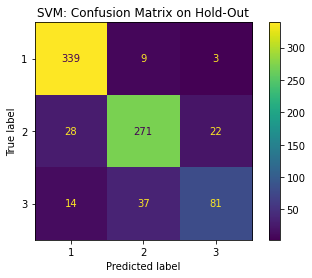

In [329]:
plot_confusion_matrix(bestmod_SVC, X_test, y_test_flat)
plt.title('SVM: Confusion Matrix on Hold-Out')
plt.show()

In [331]:
# Matthews Correlation Coefficient for hyerparameter optimized SVM with RBF Kernel
print(mcc(y_test_flat,y_predSVC))

0.7727738157051403


In [335]:
model_svm_path = "..\\models\\kernelrbfsvm_pipeline.pkl"
pickle.dump(bestmod_SVC, open(model_svm_path, 'wb'))

## Gradient Boosting + Hyperparameter Optimization

Tree-based ensemble models seem to work well on our classification problem. We tried a random forest before and found that a relatively large (~ 700) ensemble of trees of mid-size depth (18 levels) worked well. Let's see if using gradient boosting with less complex trees does as good or a better job. 

In [332]:
from xgboost import XGBClassifier #xgboost's classifier is compatible with scikit-learn pipeline and cross validation framework

In [351]:
full_pipeline.steps.pop(-1)

('scaler', MinMaxScaler())

In [352]:
full_pipeline.steps.append(('exo_xgb', XGBClassifier()))

In [355]:
parameters = {'exo_xgb__learning_rate': [.01,.05,.1,.5, 1], 'exo_xgb__max_depth': [2], 'exo_xgb__n_estimators': [50,100,500,1000]}
exo_xgb_cv = GridSearchCV(full_pipeline, param_grid = parameters, cv = 5, scoring = 'f1_micro')

In [356]:
exo_xgb_cv.fit(X_train, y_train_flat)

ing in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
C:\Users\prave\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[13:33:37] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
C:\Users\prave\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sqrtlog',
                                        SqrtLogZeroExceptionTransformer()),
                                       ('lpptrans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('lpp',
                                                                         LocalityPreservingProjection(),
                                                                         ['LCBIN_0',
                                                                          'LCBIN_1',
                                                                          'LCBIN_2',
                                                                          'LCBIN_3',
                                                                          'LCBIN_4',
                                                                          'LCBIN_5',
                        

In [366]:
pd.DataFrame(exo_xgb_cv.cv_results_).sort_values(by = 'rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_exo_xgb__learning_rate,param_exo_xgb__max_depth,param_exo_xgb__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,16.982355,0.197297,0.034572,0.001373,0.1,2,1000,"{'exo_xgb__learning_rate': 0.1, 'exo_xgb__max_...",0.869374,0.868132,0.878022,0.881319,0.871429,0.873655,0.005130,1
13,8.711669,0.185913,0.033200,0.001329,0.5,2,100,"{'exo_xgb__learning_rate': 0.5, 'exo_xgb__max_...",0.863886,0.872527,0.871429,0.885714,0.865934,0.871898,0.007632,2
14,13.117906,0.876536,0.041197,0.003488,0.5,2,500,"{'exo_xgb__learning_rate': 0.5, 'exo_xgb__max_...",0.864984,0.874725,0.871429,0.878022,0.860440,0.869920,0.006407,3
19,16.334561,0.297873,0.034779,0.003313,1,2,1000,"{'exo_xgb__learning_rate': 1, 'exo_xgb__max_de...",0.861690,0.865934,0.867033,0.883516,0.869231,0.869481,0.007434,4
17,8.618781,0.168615,0.033710,0.001943,1,2,100,"{'exo_xgb__learning_rate': 1, 'exo_xgb__max_de...",0.863886,0.861538,0.868132,0.884615,0.861538,0.867942,0.008678,5


the f1_micro averaged cross validation scores for for the top models are pretty high: both consistently on the individual splits and the average score across all folds. this seems like its going to generalize well. 

In [380]:
best_xgb_mod = exo_xgb_cv.best_estimator_

In [381]:
best_xgb_mod.fit(X_train, y_train_flat)

C:\Users\prave\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[14:17:59] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('sqrtlog', SqrtLogZeroExceptionTransformer()),
                ('lpptrans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('lpp',
                                                  LocalityPreservingProjection(),
                                                  ['LCBIN_0', 'LCBIN_1',
                                                   'LCBIN_2', 'LCBIN_3',
                                                   'LCBIN_4', 'LCBIN_5',
                                                   'LCBIN_6', 'LCBIN_7',
                                                   'LCBIN_8', 'LCBIN_9',
                                                   'LCBIN_10', 'LCBIN_11',
                                                   'LCBIN_12', 'LCBIN_13',
                                                   'LCBIN_14', 'LCBIN_15',
                                                   'LCBIN_16', 'LCB...
                               importance_type=

In [360]:
best_xgb_mod.fit(X_train, y_train_flat)

C:\Users\prave\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[13:43:26] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('sqrtlog', SqrtLogZeroExceptionTransformer()),
                ('lpptrans',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('lpp',
                                                  LocalityPreservingProjection(),
                                                  ['LCBIN_0', 'LCBIN_1',
                                                   'LCBIN_2', 'LCBIN_3',
                                                   'LCBIN_4', 'LCBIN_5',
                                                   'LCBIN_6', 'LCBIN_7',
                                                   'LCBIN_8', 'LCBIN_9',
                                                   'LCBIN_10', 'LCBIN_11',
                                                   'LCBIN_12', 'LCBIN_13',
                                                   'LCBIN_14', 'LCBIN_15',
                                                   'LCBIN_16', 'LCB...
                               importance_type=

In [382]:
y_xgb = best_xgb_mod.predict(X_test)

In [383]:
print(classification_report(y_test_flat, y_xgb))

              precision    recall  f1-score   support

           1       0.94      0.96      0.95       351
           2       0.87      0.90      0.88       321
           3       0.77      0.67      0.72       132

    accuracy                           0.89       804
   macro avg       0.86      0.84      0.85       804
weighted avg       0.89      0.89      0.89       804



The optimized XGBoost performs slightly better than the random forest on our problem (at least on our hold out set and in the 5-fold cross validation). We can see that it edges out out the random forest in precision, recall, and F1 for both class 1 and class 2. The precision/recall are lower/higher than random forest model for class 3 with the f1-score being about the same.

As a sanity check on the feature quality, let's look at the feature importances.

In [389]:
feat_cols = ['LPP_1', 'LPP_2', 'Period', 'Duration', 'even_odd_stat', 'p_secondary', 'max', 'min']
feature_xg_importance_series = pd.Series(best_xgb_mod['exo_xgb'].feature_importances_, index = feat_cols).sort_values()
print(feature_xg_importance_series)

even_odd_stat    0.044010
max              0.046027
LPP_2            0.059925
Duration         0.074929
Period           0.104650
p_secondary      0.164383
min              0.223824
LPP_1            0.282253
dtype: float32


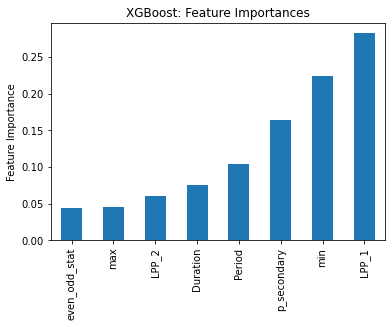

In [390]:
feature_xg_importance_series.plot(kind = 'bar')
plt.ylabel('Feature Importance')
plt.title('XGBoost: Feature Importances')
plt.show()

The XGBoost's feature importances are exactly consistent with the random forest. That reflects well on the chosen feature set.

Now let's finish this up by plotting the confusion matrix of the model on our hold-out, getting the Matthews correlation coefficient, and pickling the model.

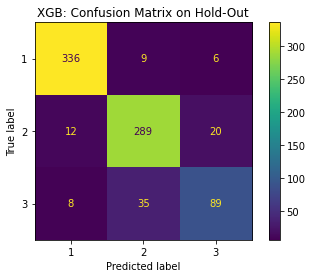

In [392]:
plot_confusion_matrix(best_xgb_mod, X_test, y_test_flat)
plt.title('XGB: Confusion Matrix on Hold-Out')
plt.show()

In [393]:
#matthews correlation coefficient
mcc_xgb = mcc(y_test_flat, y_xgb)
print(mcc_xgb)

0.8193252854415962


In [394]:
xgb_model_file_path = "..\\models\\xgb_pipeline.pkl"
pickle.dump(best_xgb_mod, open(xgb_model_file_path, 'wb'))